In [1]:
"""
Implementation of a simple multivalent binding model.
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.optimize import minimize, curve_fit
from src.MBmodel import cytBindingModel, resids, residsSeq, fitFunc, getConfInterval, getConfIntervalSeq, R2_Plot_Cells, R2_Plot_Ligs, affFit, affFitSeq

In [ ]:
x = fitFunc()

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)
0.6781685866849616


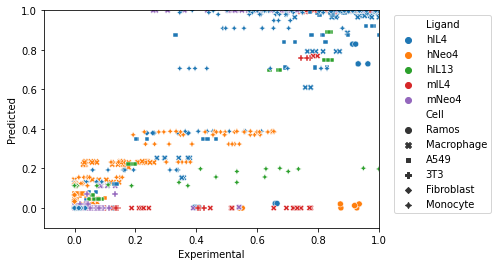

In [15]:
xOpt = pd.read_csv("src/data/CurrentFit.csv").x.values

xOpt = [-10.00000012, 7.47855207, 4.07422641, 5.28734952, 6.57725508,
4.24459969,  10.83054415,   4.33346238,   5.89440415,   9.10239707,
4.12720662,   9.68489616,   5.99999991,   1.99546303,  88.4668954,
0.16113656]
modelDF = resids(xOpt, True)
sns.scatterplot(data=modelDF, x="Experimental", y="Predicted", hue="Ligand", style="Cell")
plt.xlim(-.1, 1)
plt.ylim(-.1, 1)
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0))
#plt.savefig("UnConstrainedFit.svg")
print(r2_score(modelDF.Experimental.values, modelDF.Predicted.values))


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)
0.6876409505977293


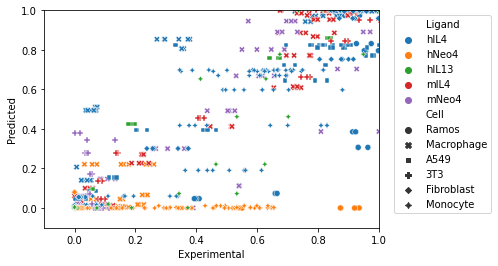

In [3]:
xOpt = pd.read_csv("src/data/CurrentFitSeq.csv").x.values
modelDF = residsSeq(xOpt, True)
sns.scatterplot(data=modelDF, x="Experimental", y="Predicted", hue="Ligand", style="Cell")
plt.xlim(-.1, 1)
plt.ylim(-.1, 1)
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0))
print(r2_score(modelDF.Experimental.values, modelDF.Predicted.values))

In [4]:
np.power(np.power(10, xOpt[2::]), -1) * np.power(10, 9)

array([8.36922251e+10, 1.00000000e+12, 3.83557898e+08, 8.30237585e+17,
       1.00000000e+05, 9.93906927e+06, 1.20695348e+12, 1.00000000e+05,
       1.54578842e+12, 4.79404088e+11, 1.99526231e+06])

In [5]:
from scipy.optimize import root, least_squares

def IL4Func(x, KDs, recs, conc):
    print(x, (x*conc)/KDs[0], recs[1]/((KDs[0]*KDs[1])/(x*conc)+1), recs[2]/((KDs[0]*KDs[2])/(x*conc)+1))
    return recs[0] - (x + (x*conc)/KDs[0] + recs[1]/(KDs[0]*KDs[1]/(x*conc)+1) + recs[2]/((KDs[0]*KDs[2])/(x*conc)+1))

KDs = [1e-7, 10, 5]
recs = [400, 5000, 10000]
conc = 1e-11
x0 = 1000
bnds = ((0, recs[0]))

IL4Ra = least_squares(IL4Func, x0=recs[0], args=(KDs, recs, conc)).x

def SignalingFunc(IL4Ra, KDs, recs, conc, T2W):
    return recs[1]/(KDs[0]*KDs[1]/(IL4Ra*conc)+1) + recs[2]/((KDs[0]*KDs[2])/(IL4Ra*conc)+1) * T2W

print(SignalingFunc(IL4Ra, KDs, recs, conc, 1))
    

[400.] [0.04] [19.92031873] [79.36507937]
[400.00000596] [0.04] [19.92031902] [79.36508054]
[320.31914882] [0.03203191] [15.96481907] [63.65602489]
[320.31915359] [0.03203192] [15.96481931] [63.65602583]
[320.34157854] [0.03203416] [15.9659334] [63.6604539]
[320.34158331] [0.03203416] [15.96593364] [63.66045484]
[79.6263873]


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)
0.8055810425089336
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


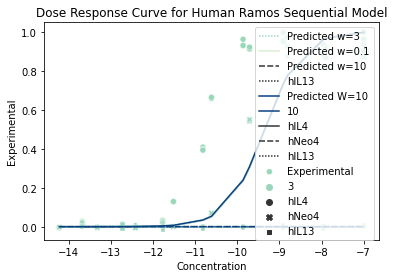

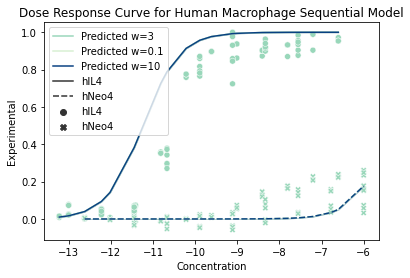

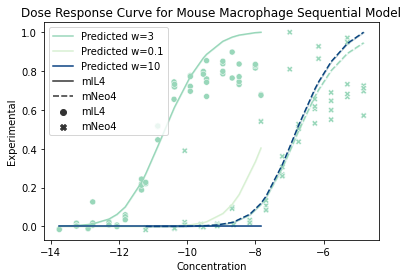

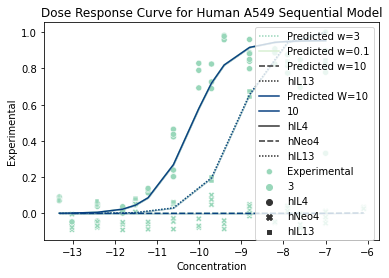

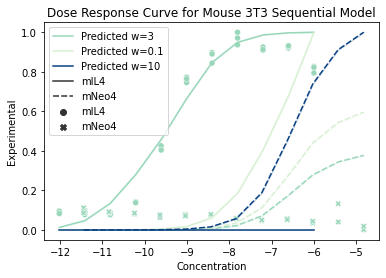

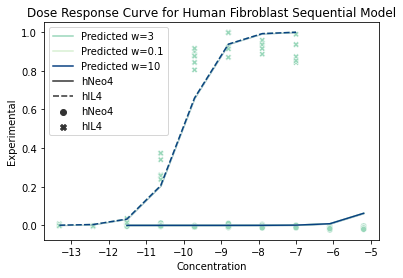

In [6]:
xOptimal = pd.read_csv("src/data/CurrentFitSeq.csv").x.values


#Generate range of xOptimals
xOpts = [xOptimal]

weights = [0.1,10]

for weight in weights:
    xOptimal_new = np.copy(xOptimal)
    xOptimal_new[0] = weight
    xOpts.append(xOptimal_new)

#print("xOpts Length "+ str(len(xOpts)))
#Generate range of models
modelDF = residsSeq(xOptimal, True)
print(r2_score(modelDF.Experimental.values, modelDF.Predicted.values))

modelDFs = [modelDF]

for i in range(1,len(xOpts)):
    modelDF_new = residsSeq(xOpts[i], True)
    modelDFs.append(modelDF_new)

#print("modelDFs Length "+ str(len(modelDFs)))


for cell in modelDF.Cell.unique():
    for animal in modelDF.loc[modelDF.Cell == cell].Animal.unique():
        weights = [3,0.1,10]
        isoData = modelDF.loc[(modelDF.Cell == cell) & (modelDF.Animal == animal)]
        #sns.set_palette("Paired")
        fig, ax = plt.subplots()
        sns.scatterplot(data=isoData, x="Concentration", y="Experimental", label="Experimental", style="Ligand",palette="GnBu", hue=3,hue_norm=(-2,10))
        for i, modelDF_ in enumerate(modelDFs):
            isoData_ = modelDF_.loc[(modelDF_.Cell == cell) & (modelDF_.Animal == animal)]
            sns.lineplot(data=isoData_, x="Concentration", y="Predicted", label="Predicted W="+str(weights[i]), style="Ligand", palette="GnBu", hue=weights[i], hue_norm=(-2,10))
        ax.set_title("Dose Response Curve for " + animal + " " + cell + " Sequential Model")
        handles, labels = ax.get_legend_handles_labels()
        #print(handles)
        #print(labels)
        ax.legend([handles[2]] + [handles[7]] + [handles[12]]+ handles[13:15] + handles[17::], ["Predicted w=3"] + ["Predicted w=0.1"] + ["Predicted w=10"] + labels[13:15] + labels[17::])
        #plt.savefig("UnConstrained"+animal+cell+".svg")

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)
0.7145518121637678


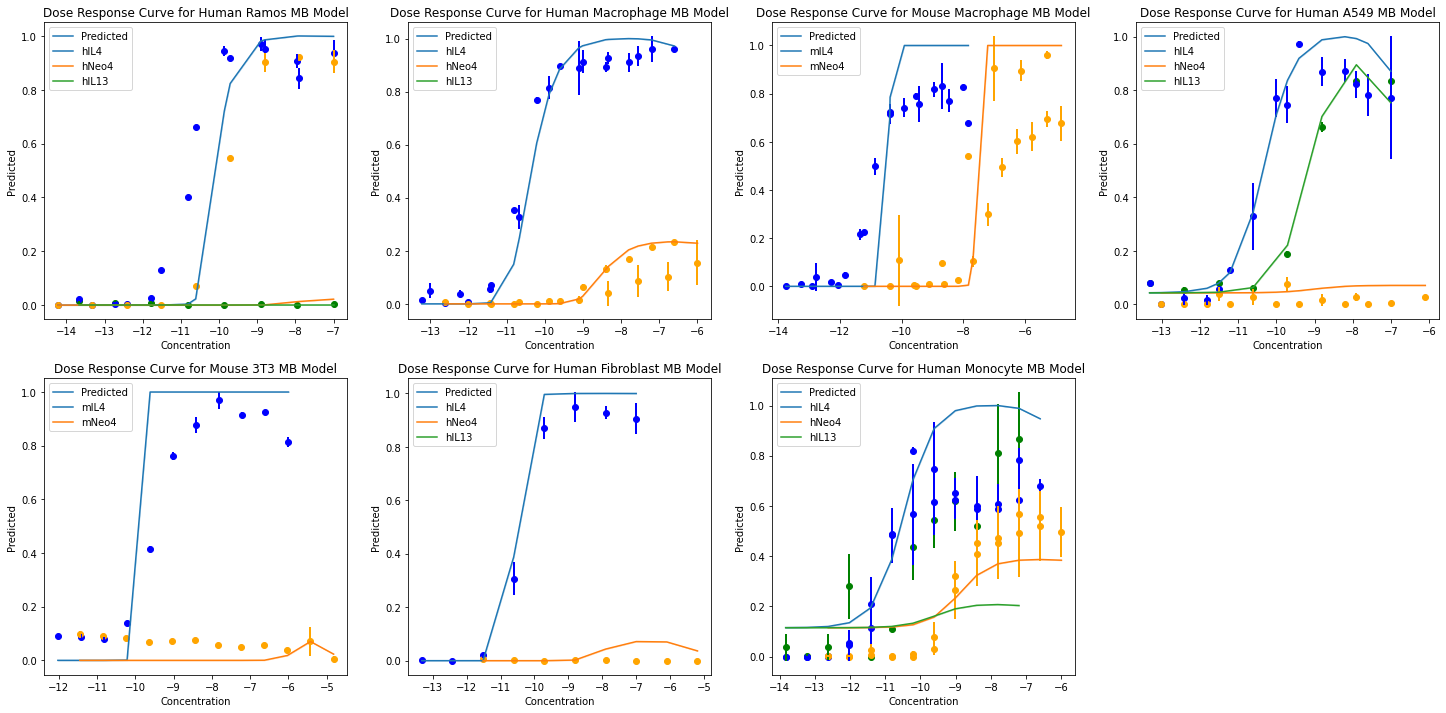

In [2]:
xOptimal = pd.read_csv("src/data/CurrentFit.csv").x.values

xOpt = [-10.00000012, 7.47855207, 4.07422641, 5.28734952, 6.57725508,
4.24459969,  10.83054415,   4.33346238,   5.89440415,   9.10239707,
4.12720662,   9.68489616,   5.99999991,   1.99546303,  88.4668954,
0.16113656]
modelDF = resids(xOptimal, True)
print(r2_score(modelDF.Experimental.values, modelDF.Predicted.values))
fig, ax = plt.subplots(2, 4, figsize=(25, 12))
ax = np.ravel(ax)
ax[-1].axis("off")
i = 0
meanDF = modelDF.groupby(["Animal", "Cell", "Ligand", "Concentration"])['Experimental'].mean().reset_index()
stdDF = modelDF.groupby(["Animal", "Cell", "Ligand", "Concentration"])['Experimental'].std().reset_index()
colorDict = {"hIL4": "blue", "hNeo4": "orange", "mIL4": "blue", "mNeo4": "orange", "hIL13": "green"}
ligOrder= ["hIL4", "hNeo4", "mIL4", "mNeo4", "hIL13"]


for cell in modelDF.Cell.unique():
    for animal in modelDF.loc[modelDF.Cell == cell].Animal.unique():
        isoData = modelDF.loc[(modelDF.Cell == cell) & (modelDF.Animal == animal)]
        means = meanDF.loc[(meanDF.Cell == cell) & (meanDF.Animal == animal)]
        stds = stdDF.loc[(stdDF.Cell == cell) & (stdDF.Animal == animal)]
        if animal == "Human":
            ligOrder= ["hIL4", "hNeo4", "hIL13"]
        else:
            ligOrder= ["mIL4", "mNeo4"]
        #sns.scatterplot(data=isoData, x="Concentration", y="Experimental", label="Experimental", hue="Ligand", ax=ax[i])
        for j, ligand in enumerate(means.Ligand.values):
            ax[i].scatter(x=means.Concentration.values[j], y=means.Experimental.values[j], color=colorDict[ligand])
            ax[i].errorbar(x=means.Concentration.values[j], y=means.Experimental.values[j], yerr=stds.Experimental.values[j], ls='none', color=colorDict[ligand], elinewidth=2, capthick=1)
        sns.lineplot(data=isoData, x="Concentration", y="Predicted", label="Predicted", hue="Ligand", ax=ax[i], hue_order=ligOrder)
        ax[i].set(title="Dose Response Curve for " + animal + " " + cell + " MB Model")
        handles, labels = ax[i].get_legend_handles_labels()
        if len(isoData.Ligand.unique()) == 3:
            ax[i].legend([handles[0]] + handles[3::], [labels[0]] + labels[3::])
        else:
            ax[i].legend([handles[0]] + handles[2::], [labels[0]] + labels[2::])
        i += 1

plt.savefig("MBDoseResponse.svg")

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)
0.7236545588492587


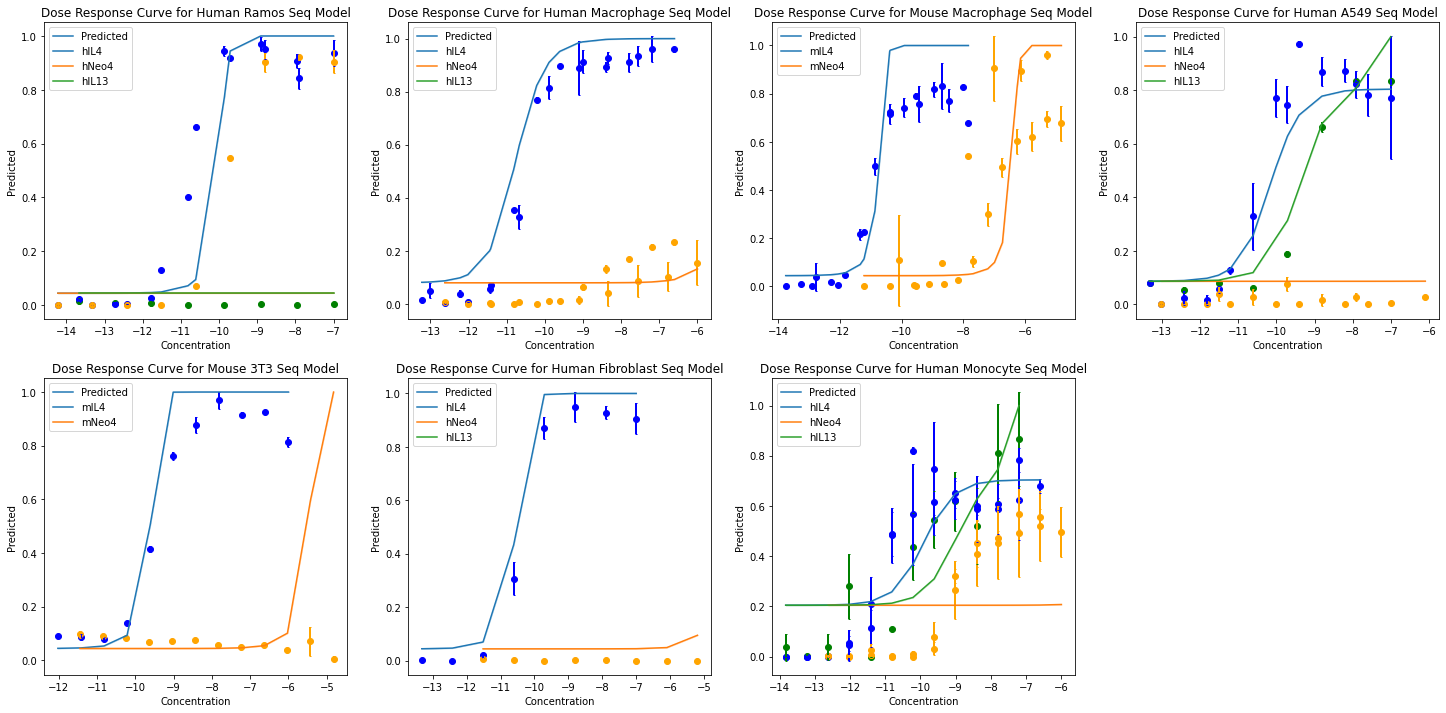

In [32]:
xOptimal = pd.read_csv("src/data/CurrentFitSeq.csv").x.values
modelDF = residsSeq(xOptimal, True)
print(r2_score(modelDF.Experimental.values, modelDF.Predicted.values))
fig, ax = plt.subplots(2, 4, figsize=(25, 12))
ax = np.ravel(ax)
ax[-1].axis("off")
i = 0
meanDF = modelDF.groupby(["Animal", "Cell", "Ligand", "Concentration"])['Experimental'].mean().reset_index()
stdDF = modelDF.groupby(["Animal", "Cell", "Ligand", "Concentration"])['Experimental'].std().reset_index()
colorDict = {"hIL4": "blue", "hNeo4": "orange", "mIL4": "blue", "mNeo4": "orange", "hIL13": "green"}
ligOrder= ["hIL4", "hNeo4", "mIL4", "mNeo4", "hIL13"]


for cell in modelDF.Cell.unique():
    for animal in modelDF.loc[modelDF.Cell == cell].Animal.unique():
        isoData = modelDF.loc[(modelDF.Cell == cell) & (modelDF.Animal == animal)]
        means = meanDF.loc[(meanDF.Cell == cell) & (meanDF.Animal == animal)]
        stds = stdDF.loc[(stdDF.Cell == cell) & (stdDF.Animal == animal)]
        if animal == "Human":
            ligOrder= ["hIL4", "hNeo4", "hIL13"]
        else:
            ligOrder= ["mIL4", "mNeo4"]
        #sns.scatterplot(data=isoData, x="Concentration", y="Experimental", label="Experimental", hue="Ligand", ax=ax[i])
        for j, ligand in enumerate(means.Ligand.values):
            ax[i].scatter(x=means.Concentration.values[j], y=means.Experimental.values[j], color=colorDict[ligand])
            ax[i].errorbar(x=means.Concentration.values[j], y=means.Experimental.values[j], yerr=stds.Experimental.values[j], ls='none', color=colorDict[ligand], elinewidth=2, capsize=1)
        sns.lineplot(data=isoData, x="Concentration", y="Predicted", label="Predicted", hue="Ligand", ax=ax[i], hue_order=ligOrder)
        ax[i].set(title="Dose Response Curve for " + animal + " " + cell + " Seq Model")
        handles, labels = ax[i].get_legend_handles_labels()
        if len(isoData.Ligand.unique()) == 3:
            ax[i].legend([handles[0]] + handles[3::], [labels[0]] + labels[3::])
        else:
            ax[i].legend([handles[0]] + handles[2::], [labels[0]] + labels[2::])
        i += 1

plt.savefig("SeqDoseResponse.svg")

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


Text(0.5, 1.0, 'Sequential binding model')

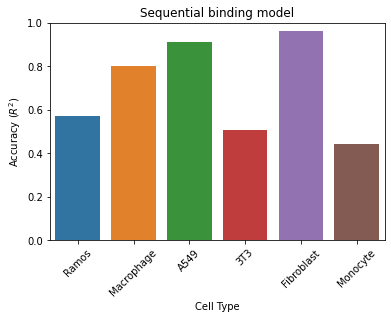

In [31]:
xOptimal = pd.read_csv("src/data/CurrentFitSeq.csv").x.values
modelDF = residsSeq(xOptimal, True)
R2_Plot_Cells(modelDF)
plt.title("Sequential binding model")

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


Text(0.5, 1.0, 'Multivalent binding model')

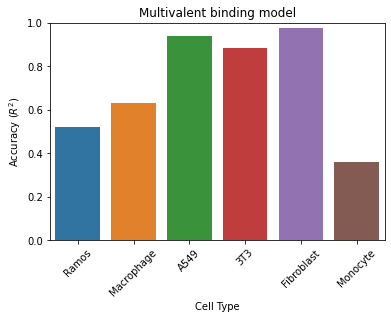

In [22]:
xOptimal = pd.read_csv("src/data/CurrentFit.csv").x.values
xOptimal = [-10.00000012, 7.47855207, 4.07422641, 5.28734952, 6.57725508,
4.24459969,  10.83054415,   4.33346238,   5.89440415,   9.10239707,
4.12720662,   9.68489616,   5.99999991,   1.99546303,  88.4668954,
0.16113656]
modelDF = resids(xOptimal, True)
R2_Plot_Cells(modelDF)
plt.title("Multivalent binding model")

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


Text(0.5, 1.0, 'Sequential binding model')

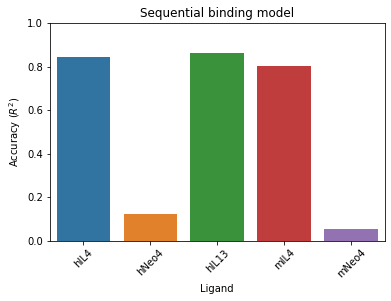

In [30]:
xOptimal = pd.read_csv("src/data/CurrentFitSeq.csv").x.values
xOptimal =  [-4.74133715e+00 , 6.63259716e-01,  5.00000000e+00, -2.02665304e+00,
  2.35664422e+00, -5.56166177e+00,  1.06066013e+00, -1.68861598e+00,
 -2.94937809e+00,  4.00137089e+00, -1.68501952e+00, -4.83427720e+00,
  2.21301681e+00,  1.40017867e+02,  2.14347034e-02]
pd.DataFrame({"x": xOptimal}).to_csv("src/data/CurrentFitSeq.csv")
modelDF = residsSeq(xOptimal, True)
R2_Plot_Ligs(modelDF)
plt.title("Sequential binding model")

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


Text(0.5, 1.0, 'Multivalent binding model')

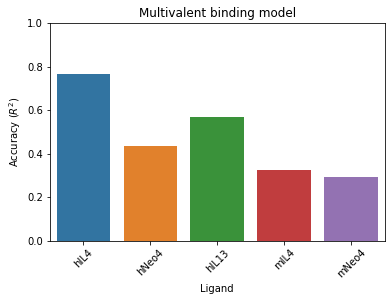

In [28]:
xOptimal = pd.read_csv("src/data/CurrentFit.csv").x.values
xOptimal = [-10.00000012, 7.47855207, 4.07422641, 5.28734952, 6.57725508,
4.24459969,  10.83054415,   4.33346238,   5.89440415,   9.10239707,
4.12720662,   9.68489616,   5.99999991,   1.99546303,  88.4668954,
0.16113656]
pd.DataFrame({"x": xOptimal}).to_csv("src/data/CurrentFit.csv")
modelDF = resids(xOptimal, True)
R2_Plot_Ligs(modelDF)
plt.title("Multivalent binding model")

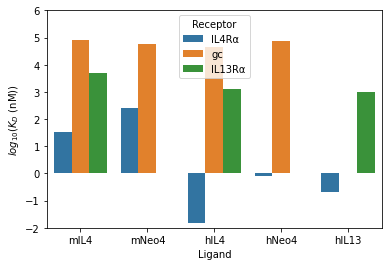

In [29]:
#confInt = getConfInterval()
affFit(np.array([False]))

  Ligand Receptor     $K_D$
0   mIL4       gc -3.492671
0   mIL4   IL13Rα -1.922559
0  mNeo4       gc  0.416139
0   hIL4       gc  4.000000
0   hIL4   IL13Rα  1.754329
0  hNeo4       gc  4.000000
0  hIL13    IL4Rα -1.578703


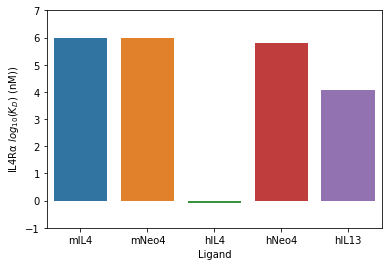

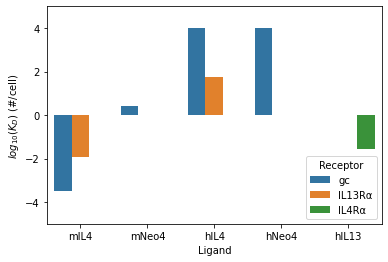

In [9]:
#confIntSeq = getConfIntervalSeq()
affFitSeq(np.array([False]))

In [14]:
import numpy as np
def sigSigmoid(complexes, EC50, hill):
    """Transforms the number of signaling complexes in a sigmoidal fashion"""
    print(complexes, EC50, hill)
    return (1 / (1 + np.exp(hill * (EC50 - complexes))))
print(sigSigmoid(np.array([50, 100]), 100, 0.02))

np.exp(1)

[ 50 100] 100 0.02
[0.26894142 0.5       ]


2.718281828459045

In [ ]:


x = [-11.41301608, 11., 4., 4.00000006, 7.35639472, 4.67034392, 11., 4.00675657, 5.9649968, 9.57944518, 4., 10.07770913, 6., 1.36836541, 86.20834146, 5.10900151]